**Author** : V.Joan Aléonard<br>
**Last update** : 23 February 2020

# <font color=red><center>OLIST MARKETPLACE - CUSTOMERS SEGMENTATION</center></font>

**OLIST Store** is a Brazilian sales solution for online marketplaces.

As Data Scientist consultant for Olist, our mission is to provide Olist e-commerce teams with a **customer segmentation** that can be used on a daily basis for communication campaigns.

The objective of this notebook is to understand the **different profiles** of Olist customers through their **behaviour and personal data**.

Thus, we will provide the marketing team with:
- an actionable description of the segmentation and its underlying logic for optimal use;
- a proposal for maintenance contract, based on the analysis of the stability of the segments over time.

In a **first notebook**, we have explored and merged the datasets provided by Olist, containing information about customer details, order history, purchased products, payment details, satisfaction feedback, etc. ([Link](https://www.kaggle.com/olistbr/brazilian-ecommerce)).

We are now ready to start our **<font color=red>clustering modeling</font>**, i.e., grouping observations (data points) based on their **similarity**.

# <font color=green><center>Notebook for MODELING</center></font>

# <font color=salmon>PART 1 - Data and Clustering methodology</font>

## <font color=blue>1.1 - Loading, shape</font>

#### Import all libraries and modules

In [1]:
# For PEP8 compliance
%load_ext pycodestyle_magic
# %pycodestyle_on
# %pycodestyle_off

In [2]:
# -*- coding: uft-8 -*-

import numpy as np
import pandas as pd
from pandas.plotting import parallel_coordinates

import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

from IPython.display import display, Markdown

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics.cluster import adjusted_rand_score

# Custom module
from my_functions import *

# Constant used for reproductibility
RANDOM_STATE = 42

# Settings
pd.options.display.float_format = '{:,.2f}'.format
%matplotlib inline
pio.renderers.default = 'notebook'

#### Load dataset and view 5 first rows

In [3]:
# Load datasets
data = pd.read_csv('p5_cleaned_customers.csv')

# Set index
data.set_index('customer_unique_id', inplace=True)

# Display shape, missing values, 5 first rows
display(Markdown(f'**MASTER DATAFRAME dimension : {data.shape}**'))
display(Markdown(
    f'**Missing values**: {list(data.isnull().sum())}'))
data.head()

**MASTER DATAFRAME dimension : (93104, 11)**

**Missing values**: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

main_region  main_category  \
customer_unique_id                                            
0000366f3b9a7992bf8c76cfdf3221e2   Southeast     furnitures   
0000b849f77a49e4a4ce2b2a4ca5be3f   Southeast  health_beauty   
0000f46a3911fa3c0805444483337064       South       supplies   
0000f6ccb0745a6a4b88665a16c9f078       North    electronics   
0004aac84e0df4da2b147fca70cf8255   Southeast    electronics   

                                    min_purchase_date    max_purchase_date  \
customer_unique_id                                                           
0000366f3b9a7992bf8c76cfdf3221e2  2018-05-10 10:56:27  2018-05-10 10:56:27   
0000b849f77a49e4a4ce2b2a4ca5be3f  2018-05-07 11:11:27  2018-05-07 11:11:27   
0000f46a3911fa3c0805444483337064  2017-03-10 21:05:03  2017-03-10 21:05:03   
0000f6ccb0745a6a4b88665a16c9f078  2017-10-12 20:29:41  2017-10-12 20:29:41   
0004aac84e0df4da2b147fca70cf8255  2017-11-14 19:45:42  2017-11-14 19:45:42   

                                  nb_orders  nb_items  ttl_revenue  \
customer_unique_id                                                   
0000366f3b9a7992bf8c76cfdf3221e2          1         1       141.90   
0000b849f77a49e4a4ce2b2a4ca5be3f          1         1        27.19   
0000f46a3911fa3c0805444483337064          1         1        86.22   
0000f6ccb0745a6a4b88665a16c9f078          1         1        43.62   
0004aac84e0df4da2b147fca70cf8255          1         1       196.89   

                                  avg_installments  avg_review purchase_time  \
customer_unique_id                                                             
0000366f3b9a7992bf8c76cfdf3221e2              8.00        5.00         6-11h   
0000b849f77a49e4a4ce2b2a4ca5be3f              1.00        4.00         6-11h   
0000f46a3911fa3c0805444483337064              8.00        3.00        18-21h   
0000f6ccb0745a6a4b88665a16c9f078              4.00        4.00        18-21h   
0004aac84e0df4da2b147fca70cf8255              6.00        5.00        18-21h   

                                  recency  
customer_unique_id                         
0000366f3b9a7992bf8c76cfdf3221e2     3.00  
0000b849f77a49e4a4ce2b2a4ca5be3f     3.00  
0000f46a3911fa3c0805444483337064    17.00  
0000f6ccb0745a6a4b88665a16c9f078    10.00  
0004aac84e0df4da2b147fca70cf8255     9.00

In [4]:
# Create a list of date feature
date_list = ['min_purchase_date', 'max_purchase_date']

# Convert to date
for col in date_list:
    data[col] = pd.to_datetime(data[col])

# Display info
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93104 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   main_region        93104 non-null  object        
 1   main_category      93104 non-null  object        
 2   min_purchase_date  93104 non-null  datetime64[ns]
 3   max_purchase_date  93104 non-null  datetime64[ns]
 4   nb_orders          93104 non-null  int64         
 5   nb_items           93104 non-null  int64         
 6   ttl_revenue        93104 non-null  float64       
 7   avg_installments   93104 non-null  float64       
 8   avg_review         93104 non-null  float64       
 9   purchase_time      93104 non-null  object        
 10  recency            93104 non-null  float64       
dtypes: datetime64[ns](2), float64(4), int64(2), object(3)
memory usage: 8.5+ MB


Our master dataset has different types of features:
- 4 numerical discrete: <code>nb_orders, nb_items, avg_installments, avg_review</code>
- 2 numerical continuous: <code>ttl_revenue, recency</code>
- 3 categorial : <code>main_region, main_category, purchase_time</code>
- 2 dates : <code>min_purchase_date, max_purchase_date</code>

## <font color=blue>1.2 - Encoding</font>

As we work with categorical variables, we need to transform these variables to numerical equivalents so that they are readable for the clustering algorithm we will use later on; we call this pre-processing method: **encoding**.

In [5]:
# Create a copy of initial data
encoded_data = data.copy()

# Select categorical features (dtype = 'object')
categorical_features = encoded_data.select_dtypes('object')

# Call function to encode categorical features
encode_label(encoded_data, categorical_features)

# Display 5 first rows
encoded_data.head()

3 columns(s) are encoded with LabelEncoder.


main_region  main_category  \
customer_unique_id                                             
0000366f3b9a7992bf8c76cfdf3221e2            4              5   
0000b849f77a49e4a4ce2b2a4ca5be3f            4              6   
0000f46a3911fa3c0805444483337064            3             10   
0000f6ccb0745a6a4b88665a16c9f078            1              2   
0004aac84e0df4da2b147fca70cf8255            4              2   

                                   min_purchase_date   max_purchase_date  \
customer_unique_id                                                         
0000366f3b9a7992bf8c76cfdf3221e2 2018-05-10 10:56:27 2018-05-10 10:56:27   
0000b849f77a49e4a4ce2b2a4ca5be3f 2018-05-07 11:11:27 2018-05-07 11:11:27   
0000f46a3911fa3c0805444483337064 2017-03-10 21:05:03 2017-03-10 21:05:03   
0000f6ccb0745a6a4b88665a16c9f078 2017-10-12 20:29:41 2017-10-12 20:29:41   
0004aac84e0df4da2b147fca70cf8255 2017-11-14 19:45:42 2017-11-14 19:45:42   

                                  nb_orders  nb_items  ttl_revenue  \
customer_unique_id                                                   
0000366f3b9a7992bf8c76cfdf3221e2          1         1       141.90   
0000b849f77a49e4a4ce2b2a4ca5be3f          1         1        27.19   
0000f46a3911fa3c0805444483337064          1         1        86.22   
0000f6ccb0745a6a4b88665a16c9f078          1         1        43.62   
0004aac84e0df4da2b147fca70cf8255          1         1       196.89   

                                  avg_installments  avg_review  purchase_time  \
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2              8.00        5.00              5   
0000b849f77a49e4a4ce2b2a4ca5be3f              1.00        4.00              5   
0000f46a3911fa3c0805444483337064              8.00        3.00              3   
0000f6ccb0745a6a4b88665a16c9f078              4.00        4.00              3   
0004aac84e0df4da2b147fca70cf8255              6.00        5.00              3   

                                  recency  
customer_unique_id                         
0000366f3b9a7992bf8c76cfdf3221e2     3.00  
0000b849f77a49e4a4ce2b2a4ca5be3f     3.00  
0000f46a3911fa3c0805444483337064    17.00  
0000f6ccb0745a6a4b88665a16c9f078    10.00  
0004aac84e0df4da2b147fca70cf8255     9.00

## <font color=blue>1.3 - Note on clustering methodology: K-Means algorithm</font>

They are numerous clustering algorithms, but for Olist, we will only use **K-Means**.

**<font color=red>K-Means clustering</font>** is one type of unsupervised machine learning algorithms from Scikit-learn cluster module ([See in scikit-learn website](https://scikit-learn.org/stable/modules/clustering.html)). 

It is important to note that clustering algorithms aim to divide a set of data into different homogeneous "packets", in the sense that the data in each subset shares common characteristics, which most often correspond to **proximity criteria (computational <font color=red>similarity</font>)** that are defined by introducing **measures and classes of <font color=red>distance</font> between objects**.

**K-Means** tries to separate samples in **k groups of equal variance**, minimizing a criterion known as the ***inertia*** (or within-cluster sum-of-squares). Inertia can be recognized as a measure of how internally coherent clusters are.

It scales well to large number of observations.

However, this algorithm requires the number of clusters **to be specified**.

---

**The algorithm has three (3) steps**:
- It chooses randomly the initial centroids (the mean which can describe all the points in a specific cluster): this step is called **initialization**;<br><br>
- It loops between the two (2) other steps:
    - it assigns each point to its nearest centroid;
    - it creates new centroids by taking the mean value of all points asssigned to each previous centroid and moving them in there;<br><br>
The algorithm repeats these last two steps until the centroids do not move significantly (convergence is reached) or until the number of iterations is reached.

# <font color=salmon>PART 2 - Simple RFM segmentation</font>

For this 1st segmentation, we will use **<font color=green>RFM metrics</font>**, which stand for Recency, Frequency and Monetary.

- **Recency** concerns the "freshness" of the customer activity in terms of purchase: for our segmentation, it is the difference between the last date of activity in Olist database and the last activity of one customer;
- **Frequency** concerns the frequency of customer transactions: as seen in the exploratory analysis, 97% of the customers have done 1 single purchase; this feature will be only relevant for customers who have made repurchase;
- **Monetary** concerns the purchasing power of customer, i.e. its capacity to spend a certain amount of money for a purchase: here, we will track the transaction value per customer segments and their total contribution to Olist revenue.

<font color=red>Recency and Frequency are to be analyzed WITH CARE</font>:
- for recency, as most of customers have done one single purchase, it is a bit unfair to compare 2017 customers to 2018 customers; we need to keep this in mind when we talk about actionable segment description;
- as well, for frequency, only 3% customer are significant, but that also means that we can analyze in depth the other 97%.

## <font color=blue>2.1 - Pre-processing</font>

Because **K-Means** clustering uses the distance as **similarity factor**, we need to **scale the data** in order to avoid high value feature, like <code>ttl_revenue</code> for instance, to dominate other features with their large ranges, resulting in a biaised analysis.

**Scaling and normalizing data is a critical step**, thus, at the beginning of each clustering try, we will apply the following pre-processing steps :
- first, we will transform right-skewed features (especially, recency and total revenue) into **log scaled** to have a normal-like distribution (to minimize the loss function while preserving the same critical points);
- then, we will **normalize** all the features with Scikit-learn **StandardScaler**.

In [6]:
# Filter the new df
filter_data = encoded_data.loc[:, ['recency', 'nb_orders',
                                   'ttl_revenue']].copy()

# Call function of pre-processing
scaled_data = log_standardization(filter_data)
scaled_data.describe()

recency  nb_orders  ttl_revenue
count 93,104.00  93,104.00    93,104.00
mean      -0.00       0.00        -0.00
std        1.00       1.00         1.00
min       -2.36      -0.16        -2.93
25%       -0.62      -0.16        -0.70
50%        0.26      -0.16        -0.05
75%        0.77      -0.16         0.60
max        1.47      66.82         5.93

## <font color=blue>2.2 - Research of optimal k clusters</font>

Another important point about **K-Means** algorithm is that it DOES NOT know the number of optimal k clusters: this is a parameter that we have to give to KMeans.

Well, but **how do we work out the 'ideal' k number of cluster**, so that we don't end up in poor clustering?

Thus, we can use different indicators by running multiple tests with different values for k, recording and analyzing the results of the following scores:
- **Silhouette score**
- **Davies-Bouldin score**: 
- **Calinski-Harabasz score**

All these scores have the same objective: they give a measure of **tightness (compactness) and/or separation of each cluster**; the optimal k is where their values are the best.

For **Elbow Method**, it minimizes **Inertia score**, which measures how tight the clusters are : "ideal" number of clusters is around this elbow.

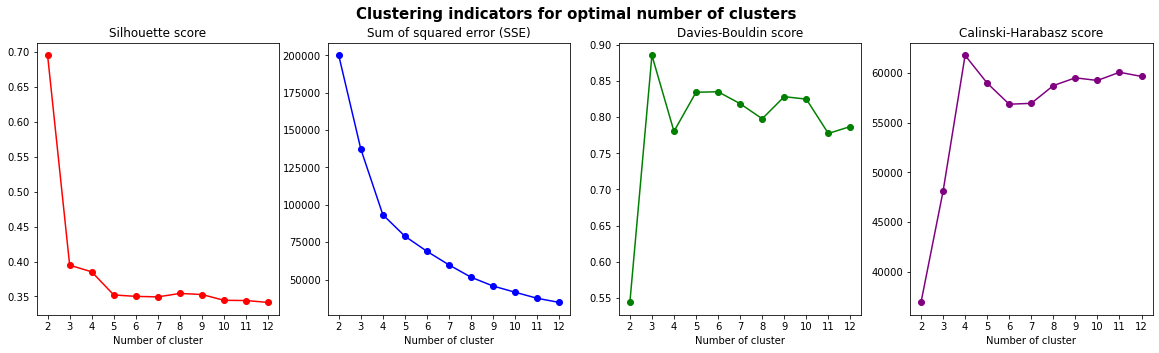

Wall time: 19min 35s


In [7]:
%%time

# Call function for optimak k evaluation
cluster_scores_plot(scaled_data, figsize=(20, 5),
                    n_labels = range(2, 13))

From this graph, we can say that **K-Means clustering with 4 segments** is the optimal one:
- One of highest silhouette score with 3k;
- The elbow of the curve;
- One of the lowest Davies-Bouldin score;
- The highest for Calinski-Harabasz score.

## <font color=blue>2.3 - Stability at initialization</font>

K-Means algorithm is **sensitive to the initialization of the centroids** (the mean points of the clusters), thus, if a centroid is initialized as 'far-off' point or too many points are linked to the same cluster centroid, it will result in **poor clustering**.

Therefore, we need to check for which number of k clusters we have the most stable centroïds initialization by asking the algorithm to repeat this initialization several times to see the variance of these centroids.

ARI: mean 100.0%, std 0.0%
ARI: mean 98.3%, std 1.2%
ARI: mean 98.5%, std 0.9%
ARI: mean 91.3%, std 9.0%


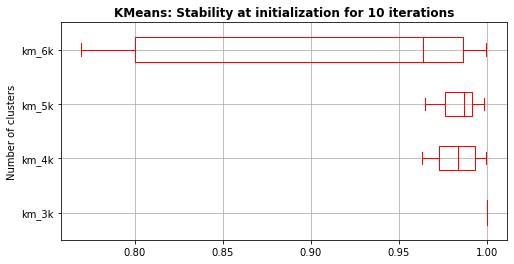

Wall time: 1min 20s


In [8]:
%%time

# Call function to check stability at initialization
plot_stability_init(scaled_data, cluster_list=[3,4,5,6], nb_iter=10)

From this graph, we can say that:
- **K-Means Clustering with 3 segments** is 100% stable;
- For **K-Means Clustering with 4 segments**, which is the recommended optimal k, has very low variations (above 95%): generally speaking, this percentage is very stable (compared to 6 segments initialization for instance).

We can now train KMeans with this number of clusters : 4.

## <font color=blue>2.4 - KMeans clustering analysis : 4 segments for RFM</font>

recency  nb_orders  ttl_revenue
segment                                  
0            1.24       1.00       130.14
1            8.76       1.00       303.12
2            6.80       2.11       308.62
3            9.42       1.00        68.26
mean_pop     7.37       1.03       165.15

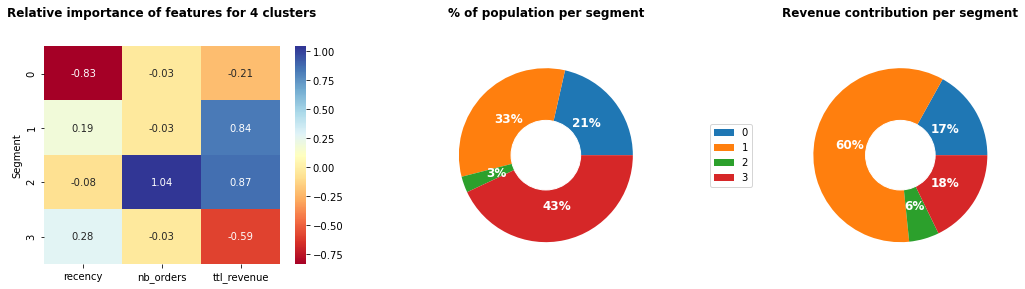

In [9]:
# Call function to analyze predicted segments
kmeans_segment_analysis(scaled_data, filter_data,
                        k=4, random_state=RANDOM_STATE)

**Building Customer persona from the cluster**:
- **Cluster 0** (21% population, 17% of revenue): Relatively recent customer with 1 below-average value purchase (to be followed)
- **Cluster 1** (33% population, 60% of revenue): Not recent customer with 1 high value purchase (kind of champions)
- **Cluster 2** (3% population, 6% of revenue): Customer with frequent purchases and high value (Loyal customers)
- **Cluster 3**(43% population, 18% of revenue): Very old customer with very low value (danger?)

But we can note that the distribution "% of population" vs. "Revenue contribution" is clearly imbalanced.

# <font color=salmon>PART 3 - RFM + Review segmentation</font>

For this new round of segmentation, in addition to RFM Metrics, we add the **customer satisfaction** with the average score they gave after a purchase: <code>avg_review</code>.

## <font color=blue>3.1 - Pre-processing</font>

In [10]:
# Filter the new df
filter_data = encoded_data.loc[:, ['recency', 'nb_orders',
                                   'ttl_revenue', 'avg_review']].copy()

# Call function of pre-processing
scaled_data = log_standardization(filter_data)
scaled_data.describe()

recency  nb_orders  ttl_revenue  avg_review
count 93,104.00  93,104.00    93,104.00   93,104.00
mean      -0.00       0.00        -0.00       -0.00
std        1.00       1.00         1.00        1.00
min       -2.36      -0.16        -2.93       -2.43
25%       -0.62      -0.16        -0.70       -0.11
50%        0.26      -0.16        -0.05        0.67
75%        0.77      -0.16         0.60        0.67
max        1.47      66.82         5.93        0.67

## <font color=blue>3.2 - Research of optimal k clusters</font>

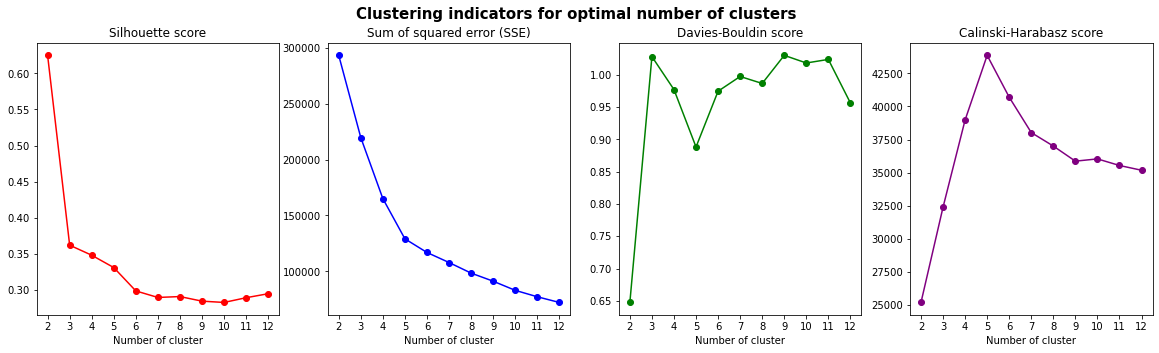

Wall time: 19min 34s


In [11]:
%%time

# Call function for optimak k evaluation
cluster_scores_plot(scaled_data, figsize=(20, 5),
                    n_labels = range(2, 13))

## <font color=blue>3.3 - Stability at initialization</font>

ARI: mean 81.0%, std 37.9%
ARI: mean 100.0%, std 0.0%
ARI: mean 99.3%, std 0.3%
ARI: mean 97.7%, std 1.3%


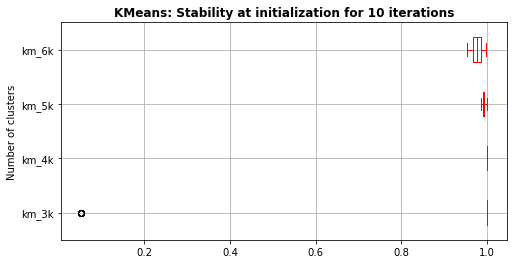

Wall time: 1min 3s


In [12]:
%%time

# Call function to check stability at initialization
plot_stability_init(scaled_data, cluster_list=[3,4,5,6], nb_iter=10)

From the scores and the stability at initialization, we try **k-Means clustering with 5 segments**.

## <font color=blue>3.4 - KMeans clustering analysis : 5 segments for RFM + Satisfaction</font>

recency  nb_orders  ttl_revenue  avg_review
segment                                              
0            9.49       1.00        66.38        4.62
1            6.80       2.11       308.62        4.19
2            7.50       1.00       174.95        1.57
3            8.96       1.00       305.09        4.65
4            1.19       1.00       129.86        4.63
mean_pop     7.37       1.03       165.15        4.14

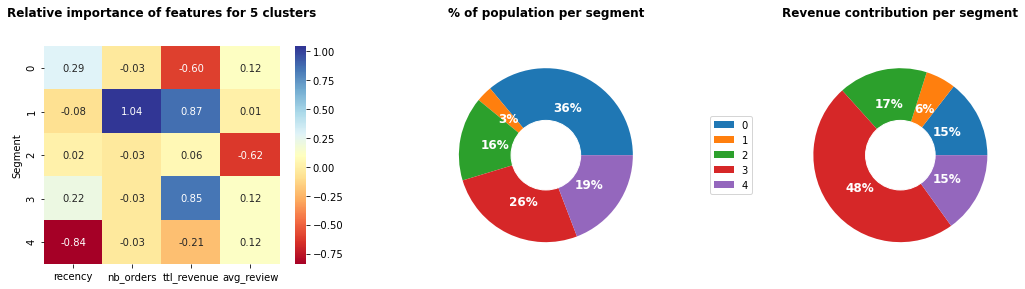

In [13]:
# Call function to analyze predicted segments
kmeans_segment_analysis(scaled_data, filter_data,
                        k=5, random_state=RANDOM_STATE)

**Building Customer persona from the cluster**:
- **Cluster 0** (36% population, 15% of revenue): Very old but happy customer with 1 very low-value purchase
- **Cluster 1** (3% population, 6% of revenue): Satisfied customer with frequent and high value purchases (Loyal customers)
- **Cluster 2** (16% population, 17% of revenue): Very **unsatisfied** customer with 1 medium purchase value (almost lost?)
- **Cluster 3** (26% population, 48% of revenue): Not recent and satisfied customer with 1 high purchase value (Champions)
- **Cluster 4** (19% population, 15% of revenue): Very recent and satisfied customer with 1 below-average purchase value

**Observations**:

Clustering with 5 segments reveals very unsatisfied customers.

# <font color=salmon>PART 4 - RFM + Reviews + Installments segmentation</font>

## <font color=blue>4.1 - Pre-processing</font>

In [14]:
# Filter the new df
filter_data = encoded_data.loc[:, ['recency', 'nb_orders', 'ttl_revenue',
                                   'avg_review', 'avg_installments']].copy()


# Call function of pre-processing
scaled_data = log_standardization(filter_data)
scaled_data.describe()

recency  nb_orders  ttl_revenue  avg_review  avg_installments
count 93,104.00  93,104.00    93,104.00   93,104.00         93,104.00
mean      -0.00       0.00        -0.00       -0.00             -0.00
std        1.00       1.00         1.00        1.00              1.00
min       -2.36      -0.16        -2.93       -2.43             -1.08
25%       -0.62      -0.16        -0.70       -0.11             -0.71
50%        0.26      -0.16        -0.05        0.67             -0.34
75%        0.77      -0.16         0.60        0.67              0.40
max        1.47      66.82         5.93        0.67              7.84

## <font color=blue>4.2 - Research of optimal k clusters</font>

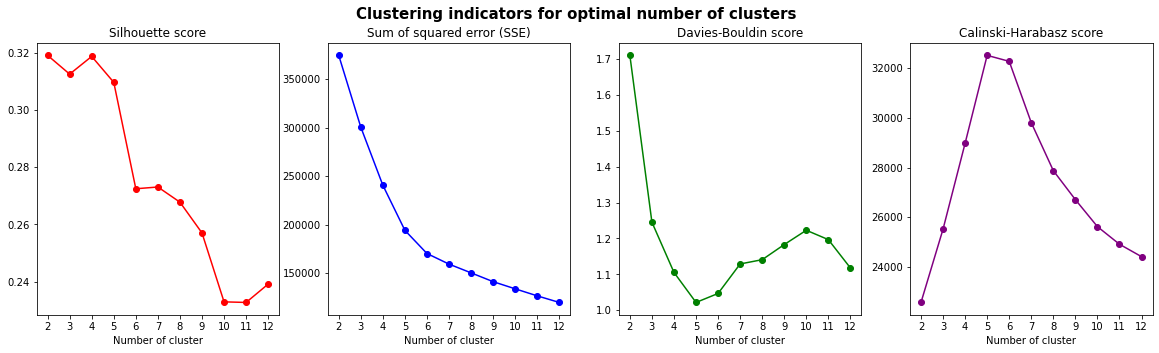

Wall time: 19min 11s


In [15]:
%%time

# Call function for optimak k evaluation
cluster_scores_plot(scaled_data, figsize=(20, 5),
                    n_labels = range(2, 13))

## <font color=blue>4.3 - Stability at initialization</font>

ARI: mean 89.9%, std 17.7%
ARI: mean 99.1%, std 0.5%
ARI: mean 99.2%, std 0.7%
ARI: mean 98.7%, std 0.4%


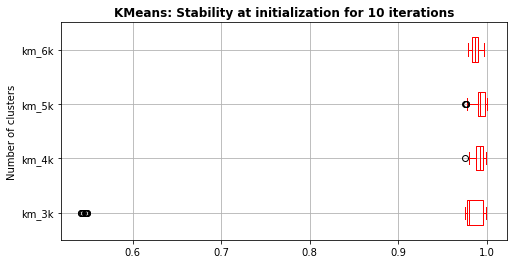

Wall time: 1min 1s


In [16]:
%%time

# Call function to check stability at initialization
plot_stability_init(scaled_data, cluster_list=[3,4,5,6], nb_iter=10)

- **K-Means clustering with 5 segments** is stable, and has very good performance on all scores;
- **K-Means clustering with 6 segments** is stable, and has good performance in all scores, except silhouette score, but is still in the highest results.

Let's try **dimensional reduction as additional performance evaluation** to validate the most qualitative clustering.

## <font color=blue>4.4 - Dimension reduction (PCA)</font>

In [17]:
%%time

# Instantiate PCA
pca = PCA(n_components=2,
          random_state=RANDOM_STATE)

# Compute PCA and get the projection of the data
X_proj = pca.fit_transform(scaled_data)

# Convert as DataFrame
columns = ['DIM{}'.format(i) for i in range(1, X_proj.shape[1]+1)]
pca_data = pd.DataFrame(X_proj, columns=columns)
# pca_data.head(3)

# Instantiate UMAP
umap = UMAP(n_components=2,
            random_state=RANDOM_STATE)
U = umap.fit_transform(X_proj)

# Instantiate T-SNE
tsne = TSNE(n_components=2,
            random_state=RANDOM_STATE)
T = tsne.fit_transform(X_proj)

Wall time: 16min 33s


[ 29.28880622  50.29095563  69.66792313  88.88936635 100.        ]


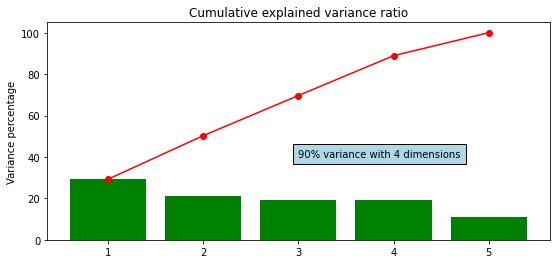

In [18]:
# Call function to plot PCA Explained variance ratio
pca_scree_plot(scaled_data, random_state=42,
               n_comp=None, threshold=None,
               text_pos=3)

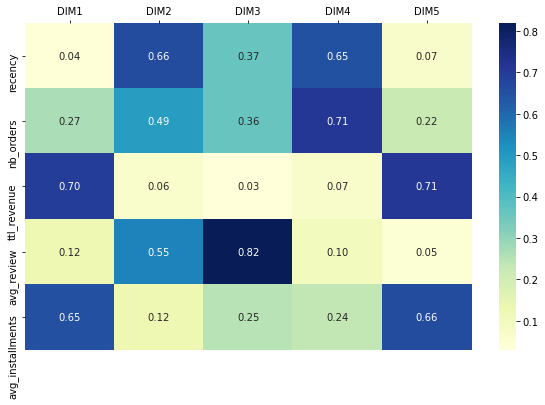

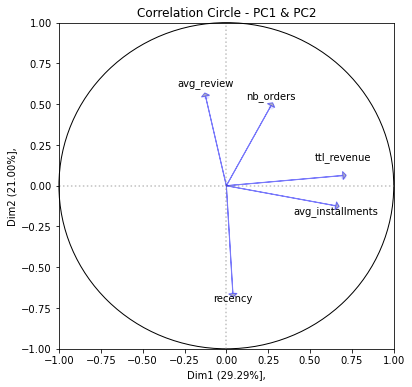

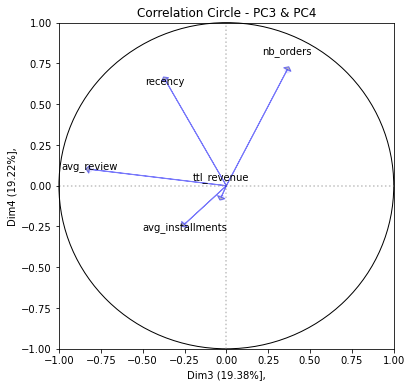

In [19]:
pca_correlation_matrix(scaled_data, n_comp=None,
                       random_state=RANDOM_STATE,
                       figsize=(10, 6))
pca_correlation_circle(scaled_data, dim_a=0, dim_b=1)
pca_correlation_circle(scaled_data, dim_a=2, dim_b=3)

## <font color=blue>4.5 - Visualization : PCA, UMAP, T-SNE</font>

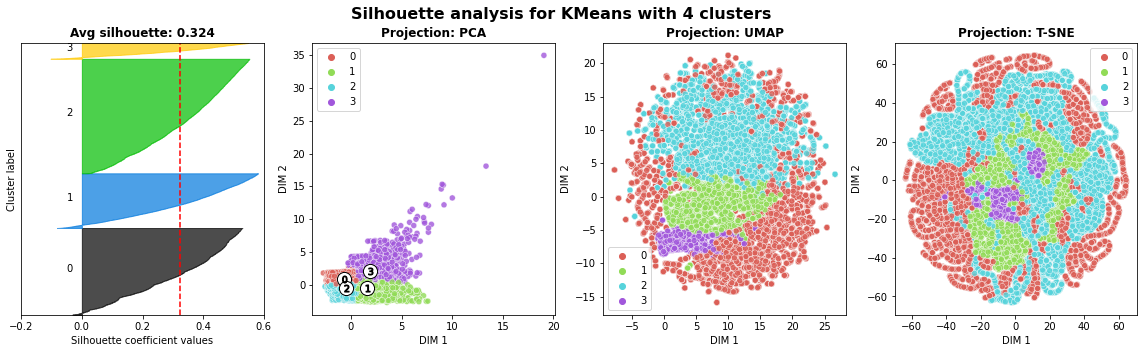

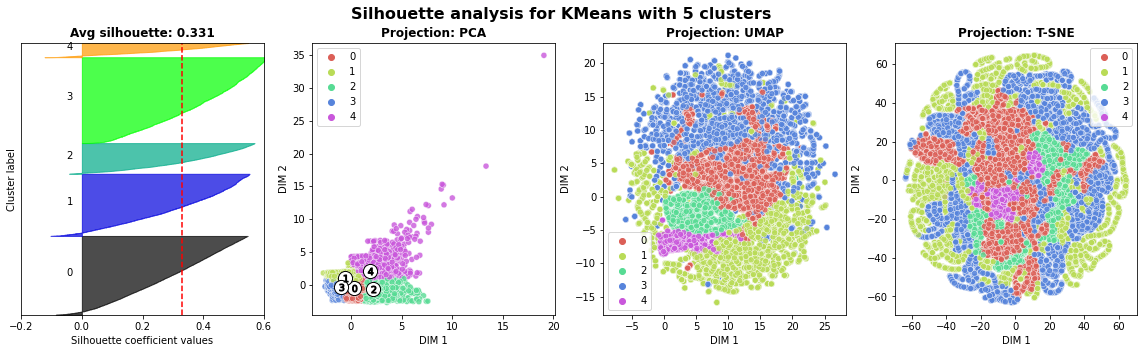

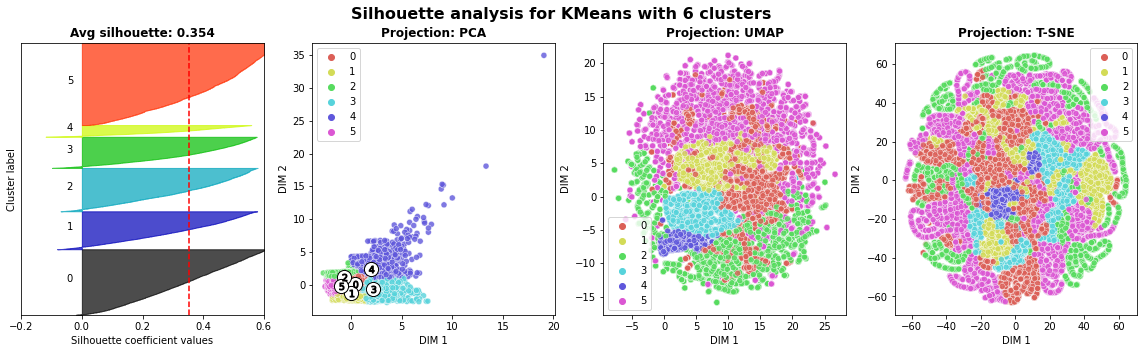

Wall time: 11min 14s


In [20]:
%%time

silhouette_pca_umap_tsne(pca_data, X_proj, U, T, k_range=[4,5,6])

Finally, it appears that **K-Means with 6 segments** has the highest silhouette score.

## <font color=blue>4.6 - KMeans clustering analysis : 6 segments for RFM + Satisfaction + Installments</font>

recency  nb_orders  ttl_revenue  avg_review  avg_installments
segment                                                                
0            9.35       1.00        57.08        4.60              1.69
1            7.99       1.00       355.20        4.24              8.50
2            7.27       1.00       149.90        1.49              2.42
3            1.15       1.00       119.48        4.63              2.09
4            6.80       2.11       308.62        4.19              3.30
5            9.19       1.00       217.05        4.65              2.21
mean_pop     7.37       1.03       165.15        4.14              2.91

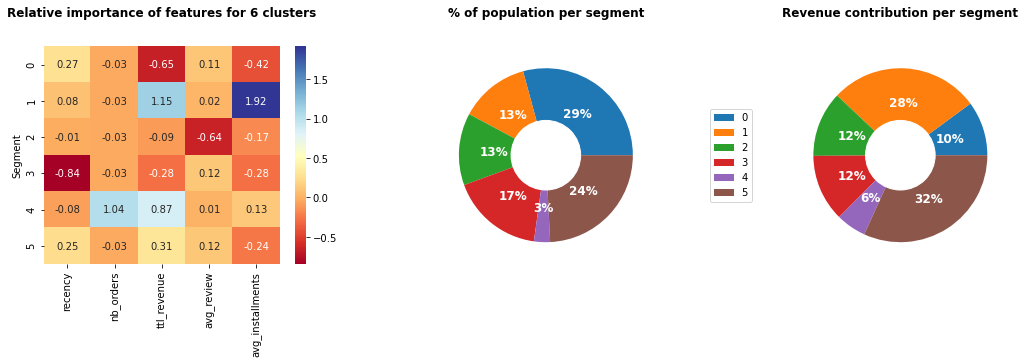

In [21]:
# Call function to analyze predicted segments
kmeans_segment_analysis(scaled_data, filter_data,
                        k=6, random_state=RANDOM_STATE)

**Building Customer persona from the cluster**:
- **Cluster 0** (29% population, 10% of revenue): Oldest but happy customer with 1 **lowest value purchase**, and almost no installments 
- **Cluster 1** (13% population, 28% of revenue): Not recent but satisfied customer with 1 highest purchase value and high installments
- **Cluster 2** (13% population, 12% of revenue): Very unsatisfied customer with 1 medium purchase value and average installments
- **Cluster 3** (17% population, 12% of revenue): Very recent and happy customer with 1 low value purchase, and low installments
- **Cluster 4** (3% population, 6% of revenue): Satisfied customer with frequent and high value purchases, and installments slightly above average
- **Cluster 5** (24% population, 32% of revenue): Old but happy customer with 1 **above-average value purchase**, and low installments

This one is interesting!

# <font color=salmon>PART 5 - Segmentation with categorical features</font>

## <font color=blue>5.1 - Pre-processing</font>

In [22]:
# Filter the new df
filter_data = encoded_data.loc[:, ['recency', 'nb_orders', 'ttl_revenue',
                                   'avg_review', 'avg_installments',
                                   'main_region', 'main_category',
                                   'purchase_time']].copy()

# Call function of pre-processing
scaled_data = log_standardization(filter_data)
scaled_data.describe()

recency  nb_orders  ttl_revenue  avg_review  avg_installments  \
count 93,104.00  93,104.00    93,104.00   93,104.00         93,104.00   
mean      -0.00       0.00        -0.00       -0.00             -0.00   
std        1.00       1.00         1.00        1.00              1.00   
min       -2.36      -0.16        -2.93       -2.43             -1.08   
25%       -0.62      -0.16        -0.70       -0.11             -0.71   
50%        0.26      -0.16        -0.05        0.67             -0.34   
75%        0.77      -0.16         0.60        0.67              0.40   
max        1.47      66.82         5.93        0.67              7.84   

       main_region  main_category  purchase_time  
count    93,104.00      93,104.00      93,104.00  
mean         -0.00          -0.00          -0.00  
std           1.00           1.00           1.00  
min          -3.04          -1.71          -1.77  
25%          -0.34          -1.03          -0.48  
50%           0.56          -0.01           0.17  
75%           0.56           0.67           0.82  
max           0.56           2.03           1.46

## <font color=blue>5.2 - Research of optimal k clusters</font>

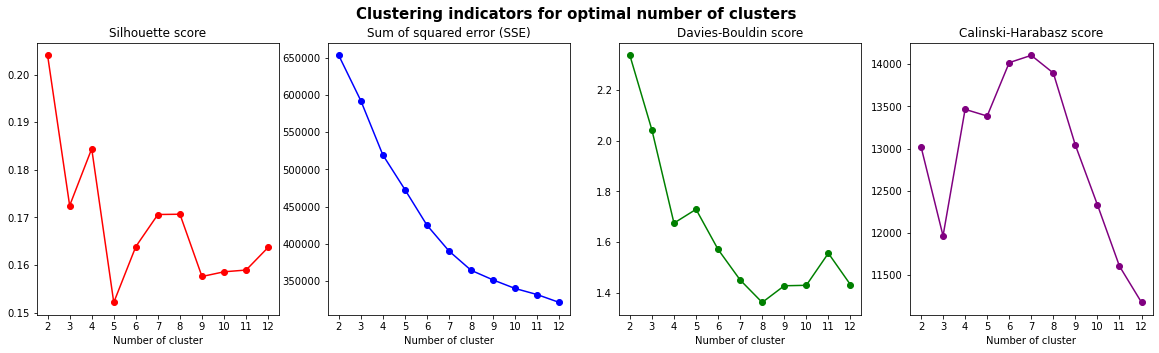

Wall time: 21min 18s


In [23]:
%%time

# Call function for optimak k evaluation
cluster_scores_plot(scaled_data, figsize=(20, 5),
                    n_labels = range(2, 13))

## <font color=blue>5.3 - Stability at initialization</font>

ARI: mean 79.2%, std 18.2%
ARI: mean 49.9%, std 24.4%
ARI: mean 54.0%, std 23.2%
ARI: mean 60.3%, std 24.5%


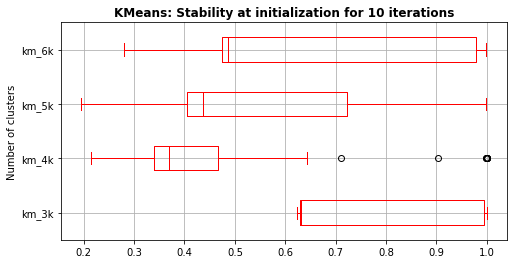

In [24]:
# Call function to check stability at initialization
plot_stability_init(scaled_data,
                    cluster_list=[3, 4, 5, 6],
                    nb_iter=10)

After multiple iterations, **this features' combinaison DOES NOT lead to good stability at initialization**.

# <font color=salmon>PART 6 - Final and actionnable segmentation</font>

As final segmentation, we choose the clustering computed at Part 4.6 :
- **6 segments** found;
- They can be described with **RFM (Recency, Frequency, Monetary) characteristics, plus review scoring and installments details**.

In [25]:
# Filter the new df
filter_data = encoded_data.loc[:, ['recency', 'nb_orders', 'ttl_revenue',
                                   'avg_review', 'avg_installments']].copy()

# Call function of pre-processing
scaled_data = log_standardization(filter_data)

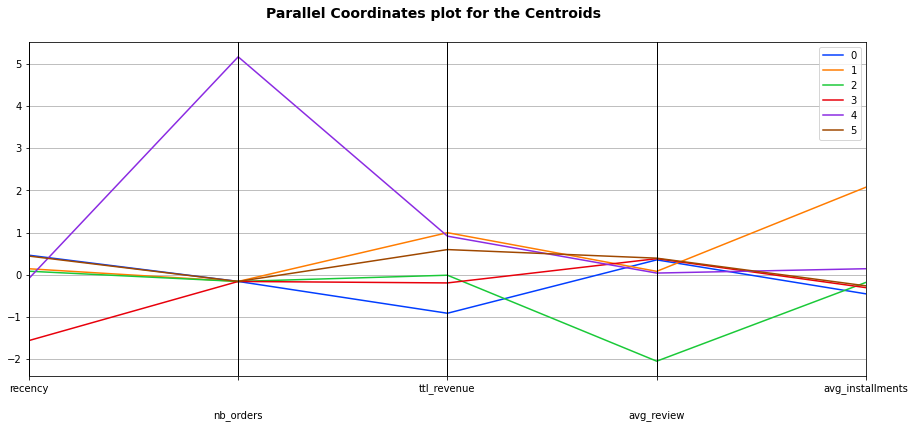

In [26]:
# Call function to display centroids
display_parallel_coordinates_centroids(scaled_data,  filter_data,
                                       n_clusters=6)

In [27]:
# Call function to plot scatterpolar
kmeans_segment_polar(scaled_data, filter_data,
                     n_clusters=6, k_range=range(0, 6))

#### **Actionable description**:
- **Clust1** (29% population, 10% of revenue): Oldest but happy customer with 1 **lowest value purchase**, and low installments 
    - Actions: **<font color=red>Small pocket</font>**, representing almost a 1/3 of the customers, whose Olist cannot afford to lose despite the low value: maybe some **aggressive price incentives** may help to reactivate them (**limited time offers, or discount coupons**)<br><br>
- **Clust2** (13% population, 28% of revenue): Not recent but satisfied customer with 1 highest purchase value and high installments
    - Actions: **<font color=red>Champions</font>**, who need **products personalization or enhanced payment facilities (new financing solutions)**<br><br>
- **Clust3** (13% population, 12% of revenue): Very unsatisfied customer with 1 medium purchase value and average installments 
    - Actions: **<font color=red>Unsatisfied</font>**, it would be wise to address the **pain points**, to advertise the **improvement of QoS (Quality of Service)**; otherwise, we can consider that these ones are **almost lost**.<br><br>
- **Clust4** (17% population, 12% of revenue): Very recent and happy customer with 1 low value purchase, and low installments
    - Actions:  **<font color=red>Relatively recent</font>**, with who Olist can **build loyalty with a welcome offer**<br><br>
- **Clust5** (3% population, 6% of revenue): Satisfied customer with frequent and high value purchases, and installments slightly above average
    - Actions: **<font color=red>Loyal</font>**, who need **loyalty programs, sponsorship programs, or simple Cross-sell/Upsell recommendations**<br><br>
- **Clust6** (24% population, 32% of revenue): Old but happy customer with 1 **above-average value purchase**, and low installments
    - Actions: **<font color=red>Inactive, good value</font>**, who may need **Special offer based on history or Cross-sell/Upsell recommendations**

# <font color=salmon>PART 7 - Stability over the time</font>

## <font color=blue>7.1 - Merged dataset loading</font>

In [28]:
pd.options.display.float_format = '{:,.3f}'.format

# Load datasets
merged_df = pd.read_csv('p5_merged_customers.csv')

# Convert to date
merged_df['purchase_date'] = pd.to_datetime(merged_df['purchase_date'])

# Display shape, min-max date, 5 first rows
display(Markdown(f'**Merged DATAFRAME dimension : {merged_df.shape}**'))
print('Min date: {}, Max date: {}'.format(merged_df.purchase_date.min(),
                                          merged_df.purchase_date.max()))
merged_df.head()

**Merged DATAFRAME dimension : (96211, 11)**

Min date: 2017-01-05 11:56:06, Max date: 2018-08-29 15:00:37


customer_unique_id customer_region  \
0  861eff4711a542e4b93843c6dd7febb0       Southeast   
1  290c77bc529b7ac935b93aa66c333dc3       Southeast   
2  060e732b5b29e8181a18229c7b0b2b5e       Southeast   
3  259dac757896d24d7702b9acbbff3f3c       Southeast   
4  345ecd01c38d18a9036ed96c73b8d066       Southeast   

                           order_id       purchase_date  purchase_hour  \
0  00e7ee1b050b8499577073aeb2a297a1 2017-05-16 15:05:35             15   
1  29150127e6685892b6eab3eec79f59c7 2018-01-12 20:48:24             20   
2  b2059ed67ce144a36e2aa97d2c9e9ad2 2018-05-19 16:07:45             16   
3  951670f92359f4fe4a63112aa7306eba 2018-03-13 16:06:38             16   
4  6b7d50bd145f6fc7f33cebabd7e49d0f 2018-07-29 09:51:30              9   

  main_category  nb_items  product_price  payment_value  payment_installments  \
0    furnitures         1        124.990        146.870                     2   
1          home         1        289.000        335.480                     8   
2    furnitures         1        139.940        157.730                     7   
3    furnitures         1        149.940        173.300                     1   
4          home         1        230.000        252.250                     8   

   review_score  
0             4  
1             5  
2             5  
3             5  
4             5

## <font color=blue>7.2 - Period of reference: 1st year</font>

In [29]:
# Get main temporal data from dataset
date_first = merged_df.purchase_date.min()
date_last = merged_df.purchase_date.max()

# Set referal data with ONE YEAR information
date_init = date_first + timedelta(days=365)

# Filter the reference dataset with time mask
timemask = merged_df.purchase_date < date_init
merged_init = merged_df[timemask]

# Display shape, missing values, 5 first rows
display(Markdown(f'**Initialized DATAFRAME dimension : {merged_init.shape}**'))
merged_init.head()

**Initialized DATAFRAME dimension : (44231, 11)**

customer_unique_id customer_region  \
0   861eff4711a542e4b93843c6dd7febb0       Southeast   
5   4c93744516667ad3b8f1fb645a3116a4           South   
7   57b2a98a409812fe9618067b6b8ebe4f       Southeast   
10  2a7745e1ed516b289ed9b29c7d0539a5       Southeast   
12  918dc87cd72cd9f6ed4bd442ed785235       Southeast   

                            order_id       purchase_date  purchase_hour  \
0   00e7ee1b050b8499577073aeb2a297a1 2017-05-16 15:05:35             15   
5   5741ea1f91b5fbab2bd2dc653a5b5099 2017-09-14 18:14:31             18   
7   1093c8304c7a003280dd34598194913d 2017-11-16 19:29:02             19   
10  8428e578bb1cf839ae26a6b7615502b9 2017-11-27 17:23:20             17   
12  83d8f70418eefd96f37b483dff430305 2017-09-09 09:54:57              9   

    main_category  nb_items  product_price  payment_value  \
0      furnitures         1        124.990        146.870   
5   sport_leisure         1        259.900        282.210   
7         unknown         1         19.900         36.010   
10            DIY         1         25.300         40.400   
12     appliances         1         99.000        117.310   

    payment_installments  review_score  
0                      2             4  
5                      1             5  
7                      3             3  
10                     1             5  
12                     1             4

In [30]:
# Call function for groupby
grouped_init = groupby_unique_customer(merged_init)

# Display shape, min-max date, 5 first rows
display(Markdown(f'**Grouped DATAFRAME dimension : {grouped_init.shape}**'))
display(
    'Min date: {}, Max date: {}'.format(grouped_init.max_purchase_date.min(),
                                        grouped_init.max_purchase_date.max()))
grouped_init.head()

**Grouped DATAFRAME dimension : (42916, 6)**

'Min date: 2017-01-05 11:56:06, Max date: 2018-01-05 11:55:26'

max_purchase_date  nb_orders  ttl_revenue  \
customer_unique_id                                                             
0000f46a3911fa3c0805444483337064 2017-03-10 21:05:03          1        86.22   
0000f6ccb0745a6a4b88665a16c9f078 2017-10-12 20:29:41          1        43.62   
0004aac84e0df4da2b147fca70cf8255 2017-11-14 19:45:42          1       196.89   
0005e1862207bf6ccc02e4228effd9a0 2017-03-04 23:32:12          1       150.12   
0006fdc98a402fceb4eb0ee528f6a8d4 2017-07-18 09:23:10          1        29.00   

                                  avg_review  avg_installments  recency  
customer_unique_id                                                       
0000f46a3911fa3c0805444483337064        3.00              8.00    10.00  
0000f6ccb0745a6a4b88665a16c9f078        4.00              4.00     2.00  
0004aac84e0df4da2b147fca70cf8255        5.00              6.00     1.00  
0005e1862207bf6ccc02e4228effd9a0        4.00              3.00    10.00  
0006fdc98a402fceb4eb0ee528f6a8d4        3.00              2.00     5.00

In [31]:
# Filter dataframe
filter_init = grouped_init.loc[:, ['nb_orders', 'recency', 'ttl_revenue',
                                   'avg_installments', 'avg_review']].copy()

scaled_init = log_standardization(filter_init)
scaled_init.describe()

nb_orders  recency  ttl_revenue  avg_installments  avg_review
count   42916.00 42916.00     42916.00          42916.00    42916.00
mean       -0.00     0.00        -0.00             -0.00        0.00
std         1.00     1.00         1.00              1.00        1.00
min        -0.16    -1.87        -2.88             -0.74       -2.49
25%        -0.16    -0.94        -0.70             -0.74       -0.12
50%        -0.16     0.29        -0.06             -0.38        0.67
75%        -0.16     0.92         0.60              0.33        0.67
max        35.89     1.57         5.97              7.42        0.67

## <font color=blue>7.3 - Iteration over following months</font>

In [32]:
%%time

# Compute Kmeans with k clusters
kmeans=KMeans(n_clusters=6, random_state=RANDOM_STATE)
kmeans.fit(scaled_init)

# Predict initial clusters
segment_init = kmeans.labels_

# Save the centroids for futur initializations
segment_centers = kmeans.cluster_centers_


# Set variables
index = -1
date_lim = date_init

# Create df to save all results (labels and ARI scores)
segment_df = pd.DataFrame()
ARI_results = pd.DataFrame()

# Iterate until we reach last date (max)
while date_lim < date_last:
    index +=1
    
    # Get new filtered data
    timemask = merged_df.purchase_date < date_lim
    merged_new = merged_df[timemask]
    
    # Call function for groupby
    grouped_new = groupby_unique_customer(merged_new)
    
    # Filter dataframe
    filter_new = grouped_new.loc[:,['nb_orders', 'recency', 'ttl_revenue',
                                     'avg_installments', 'avg_review']].copy()
    
    # Call function of pre-processing
    scaled_new = log_standardization(filter_new)
    
    # Compute Kmeans with k clusters
    kmeans=KMeans(n_clusters=6, random_state=RANDOM_STATE)
    kmeans.fit(scaled_new)
    
    # Iterate for stability
    ARI_scores = []
    
    # List of customer in initial partition 
    list_index_init = scaled_init.index
    mask = scaled_new.index.isin(list_index_init)

    # Get the new labels 
    segment_new = kmeans.labels_[mask]
    
    # Save the labels as series (for Sankey)
    name = str(date_lim.strftime('%Y%m'))
    segment_ser = pd.Series(segment_new,
                            index=list_index_init,
                            name=f'seg_'+name)
    segment_df = pd.concat([segment_df, segment_ser.to_frame()],
                           axis=1)

    # Compute and save ARI score between initial and new segments
    ARI_score = adjusted_rand_score(segment_init, segment_new)
    ARI_scores.append(ARI_score)

    # Add timestamp and ARI_scores to ARI_results df
    ARI_results.loc[index, 'period'] = date_lim
    ARI_results.loc[index, 'ARI_mean'] = np.mean(ARI_scores)
        
    # Increase limit date by 30 days for next iteration
    date_lim += timedelta(days=30)

# Display results
ARI_results

Wall time: 19.8 s


period  ARI_mean
0 2018-01-05 11:56:06      1.00
1 2018-02-04 11:56:06      0.72
2 2018-03-06 11:56:06      0.59
3 2018-04-05 11:56:06      0.56
4 2018-05-05 11:56:06      0.55
5 2018-06-04 11:56:06      0.54
6 2018-07-04 11:56:06      0.55
7 2018-08-03 11:56:06      0.54

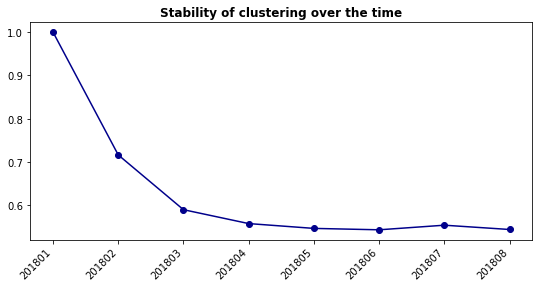

In [33]:
x = ARI_results.period.apply(lambda x: x.strftime('%Y%m'))

plt.figure(figsize=(9, 4))
plt.plot(x, ARI_results.ARI_mean, c='darkblue', marker='o')
plt.title('Stability of clustering over the time',
          fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.show()

## <font color=blue>7.4 - Sankey Diagram</font>

In [34]:
# Dispay 5 first rows
display(segment_df.shape)
display(segment_df.head())

(42916, 8)

seg_201801  seg_201802  seg_201803  \
customer_unique_id                                                     
0000f46a3911fa3c0805444483337064           4           3           2   
0000f6ccb0745a6a4b88665a16c9f078           1           0           1   
0004aac84e0df4da2b147fca70cf8255           4           3           2   
0005e1862207bf6ccc02e4228effd9a0           5           5           3   
0006fdc98a402fceb4eb0ee528f6a8d4           1           0           1   

                                  seg_201804  seg_201805  seg_201806  \
customer_unique_id                                                     
0000f46a3911fa3c0805444483337064           2           5           4   
0000f6ccb0745a6a4b88665a16c9f078           3           1           0   
0004aac84e0df4da2b147fca70cf8255           2           5           4   
0005e1862207bf6ccc02e4228effd9a0           0           0           3   
0006fdc98a402fceb4eb0ee528f6a8d4           3           1           0   

                                  seg_201807  seg_201808  
customer_unique_id                                        
0000f46a3911fa3c0805444483337064           2           4  
0000f6ccb0745a6a4b88665a16c9f078           1           1  
0004aac84e0df4da2b147fca70cf8255           2           4  
0005e1862207bf6ccc02e4228effd9a0           5           0  
0006fdc98a402fceb4eb0ee528f6a8d4           1           1

In [35]:
n_segment = segment_df.nunique().max()
n_periods = segment_df.shape[1]
# Copy df and rename columns for simplicity
temp = segment_df
temp.columns = np.arange(len(temp.columns))

all_flows = pd.DataFrame()
for i in range(n_periods-1):
    flow = temp.groupby([i, i+1]).size()
    flow = flow.rename(f'flow_{i}_{i+1}').to_frame()
    # Add line when flow is empty (set to 0)
    new_index = [(x, y) for x in range(n_segment) for y in range(6)]
    flow = flow.reindex(new_index).fillna(0).reset_index()
    flow = flow.rename(columns={i:'source', i+1:'target'})
    flow['source'] = flow['source'].add(n_segment*i)
    flow['target'] = flow['target'].add(n_segment*(i+1))
    flow.columns = ['source', 'target', 'flows']
    all_flows = pd.concat([all_flows, flow], ignore_index=True)

# Dispay 5 first rows
display(all_flows.shape)
display(all_flows.head())

(252, 3)

source  target   flows
0       0       6   72.00
1       0       7 5015.00
2       0       8    0.00
3       0       9   65.00
4       0      10   12.00

In [36]:
# Create Sankey labels
# Loop over periods and segment labels

labels = []
for i in range(1, n_periods+1):
    for j in range(n_segment):
        labels.append(f'seg{j}_p{i}')

# Define the list of colors for nodes and flows
colors_nodes = (
    [f'rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, {1})'\
     for r, g, b in sns.color_palette('hls')[:n_segment]]*n_segment*n_periods)

# Plotting the Sankey diagram
fig = go.Figure(data=[go.Sankey(valueformat = '.0f',
                                valuesuffix = 'customers',
                                node = dict(pad = 10,
                                            thickness = 20,
                                            line = dict(color='lightgrey',
                                                        width=0.5),
                                            label = labels,
                                            color = colors_nodes),
                                link = dict(source = all_flows['source'],
                                            target = all_flows['target'],
                                            value = all_flows['flows'],
                                            color = 'rgba(10,10,10,0.2)'
                                           ))])

fig.update_layout(title={'text':'SANKEY Diagram',
                         'y':0.95, 'x':0.5,
                         'xanchor':'center',
                         'yanchor':'top'}, font_size=10)
fig.show()

**We recommend a maintenance contrat every 2-3 months**.

# <font color=salmon>PART 8 - What about other clustering algorithms?</font>

As said earlier in PART 1.1.3, **Scikit-Learn** cluster module proposes plenty of unsupervised machine learning algorithms. 

We have tested 2 others models on side notebook, to have a general overview of clustering possibilities with:
- **Agglomerative Clustering**;
- **DBSCAN (*Density-Based Spatial Clustering of Applications with noise*)**.

Our conclusion is that:
- Agglomerative Clustering is not adapted to large dataset: the execution of the algorithm literally crashed the computer, another test with 15,000 samples (~15% of the total dataset) was already computationaly heavy; we abandoned this model;<br><br>
- DBSCAN is an **interesting algorithm**, because it doesn't require the number of cluster to be defined and the computation time was relatively short on the total dataset; it has limited the number of cluster to 4 (see below) with very good silhouette score (0.53 vs 0.35 for K-Means). However, there is a real drawback: DBSCAN concept is based on neighborhood notion, which is not adapted to our data, therefore, DBSCAN was not able to find more precise segments apart from single purchase vs. repurchase.

In [42]:
%%time

# Compute DBSCAN
dbs = DBSCAN(eps=1, min_samples=5).fit(scaled_data)

# List of clusters and their respective points
core_samples_mask = np.zeros_like(dbs.labels_, dtype=bool)
core_samples_mask[dbs.core_sample_indices_] = True
dbs_labels = dbs.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(dbs_labels)) - (1 if -1 in dbs_labels else 0)
n_noise_ = list(dbs_labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print('Silhouette Coefficient: %0.3f' % silhouette_score(scaled_data, dbs_labels))

Estimated number of clusters: 4
Estimated number of noise points: 119
Silhouette Coefficient: 0.533
Wall time: 4min 31s


recency  nb_orders  ttl_revenue  avg_review  avg_installments
segment                                                               
-1          5.99       2.97      1160.86        3.50              9.39
 0          7.39       1.00       160.06        4.14              2.89
 1          6.84       2.00       282.45        4.18              3.26
 2          6.74       3.00       396.68        4.52              2.82
 3          9.00       1.00       576.73        4.36             24.00

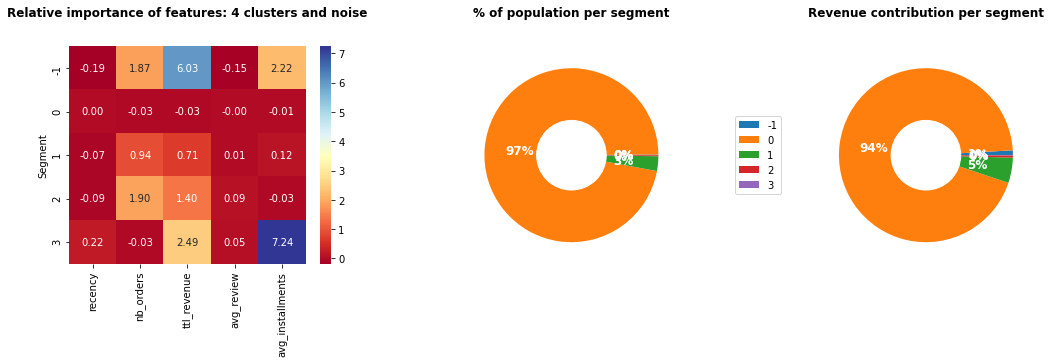

In [43]:
dbscan_segment_analysis(filter_data, dbs_labels,
                        random_state=42)

# <font color=salmon>PART 9 - Conclusion</font>

We have applied a clustering algorithm to Olist customer data.

However, we have faced some bottlenecks we want to raise:
- Incomplete customers data: a segmentation requires more precise information about customers (age, sexe, etc.);
- Complex customers data: 97% with only 1 purchase, which is not very realistic, if we talk about marketplaces;
- Marketing Team function: having some ideas of Marketing possible actions, like general priorities to reach on revenue, aquisition, retention, products etc. would have been helpful to create really useful features to improve the segmentation.

Depending on the main objective of Marketing Team, maybe the choice of the algorithm could have been different, as well as the data we would have used to perform the clustering.

Anyway, **K-Means algorithm** is very easy to implement, and is really adapted to big datasets like ours.

We met our objective: **find an actionable segmentation for Marketing Team**.
<br><br>
<center>Thanks for reading and stay tuned for the next machine learning adventure!</center>